# Bestmöglichen Parameter für die Elo-Formel finden

## 5.1 Bedeutung der Elo-Zahl

### 5.1.1 Elo-Zahl vs. Gewinnrate

Der Elo-Wert ist die Spielstärke, die Gewinnrate eine Bilanz.

Analogie: Ein Boxer mit einer Bilanz von 50 Siegen und 0 Niederlagen ist nicht zwangsläufig besser als einer mit 45 Siegen und 5 Niederlagen. Wenn der erste nur gegen Amateure gekämpft hat und der zweite nur gegen Weltmeister, ist der zweite Boxer der weitaus stärkere.

### 5.1.2 Elo-Zahlen im Schach

| Perzentil | Elo (ab) | Titel                                  | Interpretation                        | Gespielte Partien in der DB  |
|-----------|----------|----------------------------------------|---------------------------------------|------------------------------|
| –         | 1000     | Amateur Klasse E                       | Frisch eingestiegen                   | –                            |
| –         | 1200     | Amateur Klasse D                       | die Regeln beherrschen                | –                            |
| 10%       | 1300     |                                        | Anfänger                              | –                            |
| –         | 1400     | Amateur Klasse C                       | Anfänger mit ersten Erfolgen          | –                            |
| 25%       | 1500     |                                        | Durchschnittlicher Vereinsspieler     | 1                            |
| –         | 1600     | Amateur Klasse B                       | gelegentliche Spieler                 | –                            |
| 50%       | 1700     |                                        | Solider, regelmäßiger Turnierspieler  | 3                            |
| –         | 1800     | Amateur Klasse A                       | Sehr guter Vereinsspieler             | –                            |
| 75%       | 1900     |                                        |                                       | 17                           |
| –         | 2000     |                                        |                                       | –                            |
| 90%       | 2100     | Meisteranwärter                        | Experte                               | 116                          |
| 95%       | 2200     | Meisterkandidat (Candidate Master, CM) |                                       | 324                          |
| –         | 2300     | FIDE-Meister (FM)                      |                                       | –                            |
| 99%       | 2400     | Internationaler Meister (IM)           |                                       | 1595                         |
| 99.9%     | 2500     | Großmeister (GM)                       | Die absolute Weltspitze               | 4992                         |

* Unterhalb 2000 Elo-Punkten gibt es keine offiziellen Titel, weshalb eine objektive Benennung der Spielstärke schwierig ist. Zur groben Einschätzung kann in Deutschland der DWZ-Schnitt der Amateurligen dienen. Die Deutsche Wertzahl DWZ ist zwar nicht dasselbe wie die international übliche ELO-Zahl, aber vergleichbar.

* Die Verteilung der FIDE-Elo-Werte (Stand 2024) im Schach sind sind annähernd normalverteilt:
    * Mittelwert: ~1650 - 1700
    * Standardabweichung: ~200 - 250

## 5.2 Daten erkunden

### 5.2.1 Wieviele Spieler haben wieviele Partien gespielt?

* Es gibt über 100.0000 Spieler in der Datenbank.
* Aber davon haben 25% nur einmal gespielt und die Hälfte max. nur dreimal.
* Auswertbar sind vielleicht 30% (100-70) mit einer Spielerfahrung von 10 Partien.
* 10% (100-90) haben mehr als 100 Partien gespielt, die vermutlich ausgezeichnete Spieler sind.

In [ ]:
#import numpy as np
#import pandas as pd
#import sqlite3
#import matplotlib.pyplot as plt
#import seaborn as sns

In [79]:
# Anzahl der Partien pro Spieler abfragen

import pandas as pd
import sqlite3

DB_PATH = "../data/bsw/bsw.sqlite"
conn = sqlite3.connect(f"file:{DB_PATH}?mode=ro", uri=True)

query = """
    SELECT pr.player_id, count(*) AS num_games
    FROM players_rounds AS pr
    INNER JOIN rounds AS r ON pr.round_id = r.id
    INNER JOIN games AS g ON r.game_id = g.id
    WHERE g.error_code = 0 AND g.player_changed = 0 AND r.round_index = 0
    GROUP BY pr.player_id;
"""

player_exp_df = pd.read_sql_query(query, conn)
conn.close()

# Analyse der Verteilung
print("\nStatistische Verteilung der Spielerfahrung:")
player_exp_df['num_games'].describe(percentiles=[.1, .25, .50, .70, .75, .90, .95, .99, .999])


Statistische Verteilung der Spielerfahrung:


count    111107.000000
mean         77.790490
std         381.916331
min           1.000000
10%           1.000000
25%           1.000000
50%           3.000000
70%          11.000000
75%          17.000000
90%         116.000000
95%         324.000000
99%        1595.000000
99.9%      4991.866000
max       28211.000000
Name: num_games, dtype: float64

* count 111107.0: Das ist die Gesamtzahl der Spieler, für die die Statistik berechnet wurde. Deine SQL-Abfrage hat 111.107 einzigartige Spieler gefunden, die mindestens eine fehlerfreie Partie ohne Spielerwechsel gespielt haben. Das ist die 100%-Marke.
* 10% 1.0: Das bedeutet: 10% aller 111.107 Spieler haben genau 1 Partie gespielt.
* 25% 1.0: Das bedeutet: 25% aller Spieler (also ca. 27.777 Spieler) haben 1 oder weniger Partien gespielt. Da man nicht weniger als 1 spielen kann, heißt das: 25% der Spieler haben genau 1 Partie gespielt. (Die Tatsache, dass der Wert bei 10% und 25% gleich ist, zeigt, wie viele Spieler nach nur einem Spiel aufhören).
* 50% 3.0 (der Median): Das bedeutet: 50% aller Spieler (die "untere Hälfte", ca. 55.554 Spieler) haben 3 oder weniger Partien gespielt. Die andere Hälfte hat mehr als 3 Partien gespielt.
* 70% 11.0: 70% aller Spieler haben 11 oder weniger Partien gespielt.
* 90% 116.0: 90% aller Spieler haben 116 oder weniger Partien gespielt. Umgekehrt bedeutet das: Nur die Top 10% der Spieler haben mehr als 116 Partien gespielt. Das sind deine "Vielspieler".
* 99% 1595.0: Nur 1% der Spieler (die absolute Elite, ca. 1.111 Spieler) haben mehr als 1595 Partien gespielt.

### 5.2.2 Wieviele Partien wurden von erfahrenen Spielern gespielt?

* Die Datenqualität für erfahrene Spieler ist exzellent: Pool von über 1 Million Partien (die Summe der Balken ab "201-500"), die ausschließlich unter erfahrenen bis sehr erfahrenen Spielern stattgefunden haben.

* Schwellenwert für "gute Spieler": Ein sinnvoller Schwellenwert für "gute Spieler" könnte bei mindestens 100 oder sogar 200 Partien liegen. Damit schließe ich die Gelegenheitsspieler aus und fokussiere mich auf den Kern der aktiven Community, wo das Spiel "ernsthafter" gespielt.

In [14]:
%%sql
SELECT count(*) AS num_games FROM games WHERE error_code = 0 AND player_changed = 0;

,num_games
0,2160767


In [23]:
%%sql
SELECT min_player_num_games, COUNT(*) AS num_games
FROM (
    SELECT g.id AS game_id, MIN(p.num_games) AS min_player_num_games
    FROM games AS g
    INNER JOIN rounds AS r ON g.id = r.game_id
    INNER JOIN players_rounds AS pr ON r.id = pr.round_id
    INNER JOIN players AS p  ON pr.player_id = p.id
    WHERE g.error_code = 0 AND g.player_changed = 0 AND r.round_index = 0
    GROUP BY g.id
)
GROUP BY min_player_num_games;

,min_player_num_games,num_games
0,1,36037
1,2,21502
2,3,16634
3,4,13963
4,5,12822
...,...,...
2319,8045,30
2320,8061,4
2321,8564,3
2322,8846,2


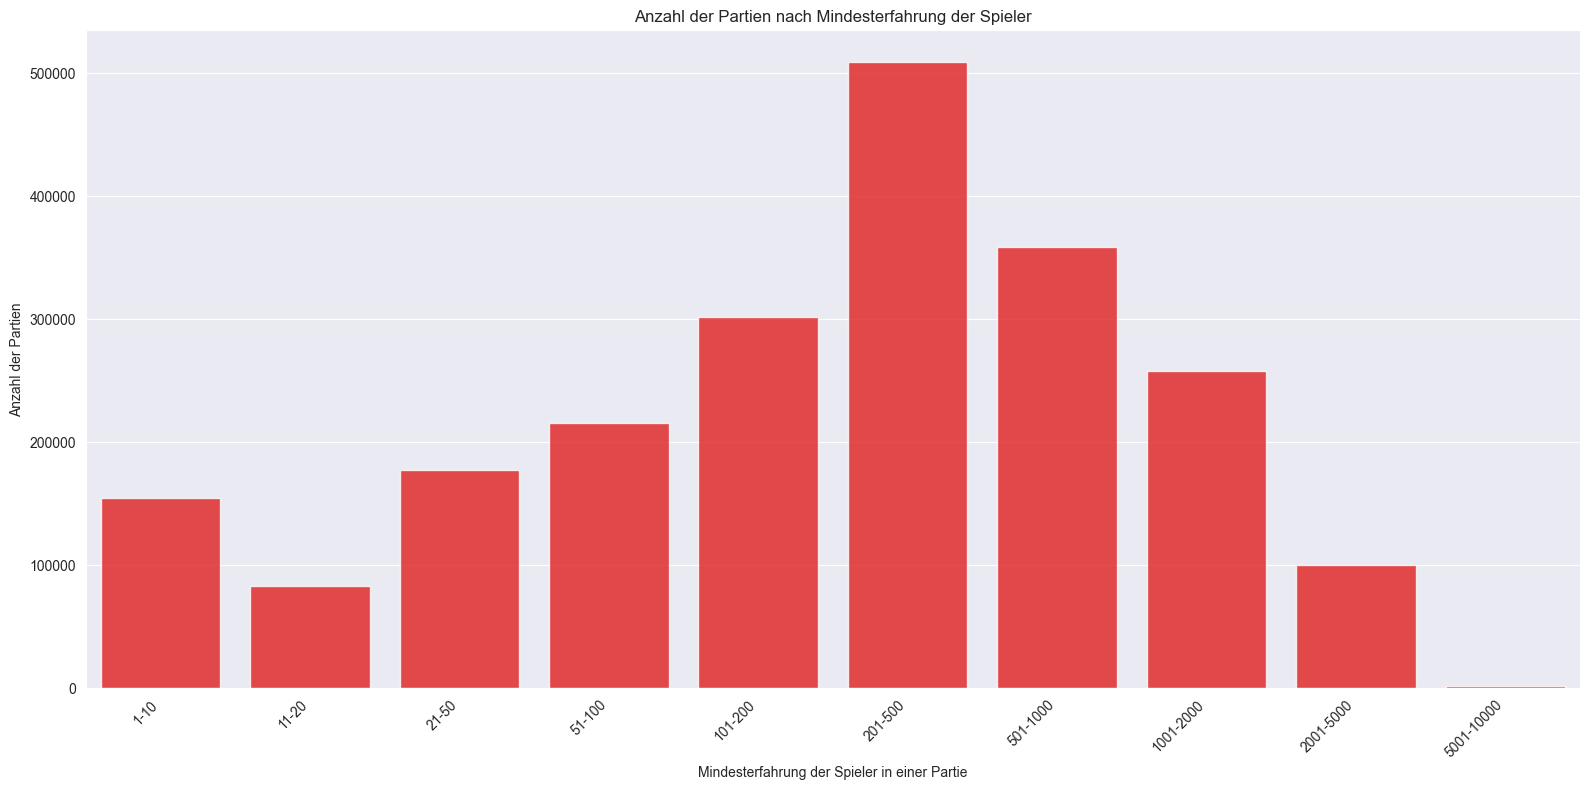

In [61]:
# Bardiagramm

import matplotlib.pyplot as plt
import seaborn as sns
#import numpy as np

# Definiere die Bins (Gruppen) für die x-Achse.
# Wir verwenden eine logarithmische Skala für die Bins, da die Daten so verteilt sind
# bins = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
bins = [0, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
labels = [f'{bins[i]+1}-{bins[i+1]}' for i in range(len(bins)-1)]

# Füge eine neue Spalte zum DataFrame hinzu, die angibt, zu welchem Bin jeder Wert gehört
df_sql1['experience_bin'] = pd.cut(df_sql1['min_player_num_games'], bins=bins, labels=labels, right=True)

# Gruppiere nach diesen Bins und summiere die Anzahl der Partien
binned_df = df_sql1.groupby('experience_bin', observed=False)['num_games'].sum().reset_index()

# Erzeuge das Balkendiagramm
plt.figure(figsize=(16, 8))
sns.barplot(x='experience_bin', y='num_games', data=binned_df, color='red', alpha=0.8)

# Achsentitel und Diagrammtitel
plt.xlabel('Mindesterfahrung der Spieler in einer Partie')
plt.ylabel('Anzahl der Partien')
plt.title('Anzahl der Partien nach Mindesterfahrung der Spieler')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Interpretation**

* Balken "1-10" (ca. 150.000 Partien): Es gibt eine beträchtliche Anzahl von Partien, in denen mindestens ein Neuling dabei ist. Das sind die typischen "Schnupperrunden" oder Runden, in denen ein erfahrener Spieler einen Freund mitbringt.

* Balken "11-20" (deutlicher Abfall auf < 100.000 Partien): Das ist der "Filter". Viele Spieler, die nur mal reinschnuppern, hören nach wenigen Partien wieder auf. Spieler mit 11-20 Partien sind in einer Übergangsphase – sie sind keine blutigen Anfänger mehr, aber auch noch keine Veteranen. Es gibt relativ wenige Partien, bei denen ein Spieler aus genau dieser Gruppe der Unerfahrenste ist.

* Der überraschende Anstieg ("21-50" bis "101-200"): Hier wird es spannend. Die Anzahl der Partien steigt wieder stark an. Das bedeutet: Partien, bei denen der unerfahrenste Spieler schon 50 oder 100 Spiele hinter sich hat, sind häufiger als Runden mit Fast-Anfängern. Das deutet auf eine starke "Stammspieler"-Kultur hin.

* Der Gipfel (Peak) bei "201-500" (über 500.000 Partien): Das ist die wichtigste Erkenntnis. Die mit Abstand größte Gruppe von Partien sind solche, bei denen alle vier Spieler am Tisch bereits mindestens 201 Partien gespielt haben. Das ist das Herz der Tichu-Community. Es sind keine gemischten Runden mehr, sondern Runden unter erfahrenen Spielern. Dies könnte durch Freundeslisten, Turniere oder einfach durch die Tatsache erklärt werden, dass erfahrene Spieler bevorzugt mit anderen erfahrenen Spielern zusammenspielen.

* Der Abfall danach ("501-1000" und folgende): Nach dem Peak beginnt der erwartete "Long Tail". Es wird zunehmend seltener, vier Spieler zu finden, die alle eine Mindesterfahrung von 500, 1000 oder mehr Partien haben. Aber selbst in der Kategorie "1001-2000" gibt es immer noch eine riesige Anzahl von über 250.000 Partien.

## 5.3 Datengetriebene Optimierung der Elo-Parameter

Ziel ist es, die bestmöglichen Parameter für das Elo-System zu finden, die den Fehler zwischen der vorausgesagten Gewinnwahrscheinlichkeit und dem tatsächlichen Ergebnis minimiert. Das ist ein klassisches Optimierungsproblem.

Die Formel für den Erwartungswert e in der Elo-Berechnung (e20 = 1 / (1 + 10^...)) gibt eine Wahrscheinlichkeit (einen Wert zwischen 0 und 1) zurück. Das tatsächliche Ergebnis s wird ebenfalls auf diesem Bereich abgebildet (1 für Sieg, 0.5 für Unentschieden, 0 für Niederlage).

Der **mittlere quadratische Fehler (Mean Squared Error; MSE = (s - e)²)** ist die Standard-Verlustfunktion (Loss Function) für die Messung des Fehlers zwischen einer vorhergesagten (erwarteten) Wahrscheinlichkeit e und einem binären/kategorischen (tatsächlichen) Ergebnis s.

MSE als Fehlerfunktion ist hier also genau die richtige Wahl.

In [5]:
# Daten abfragen

import sqlite3
import numpy as np
import pandas as pd

DB_PATH = "../data/bsw/bsw.sqlite"
conn = sqlite3.connect(f"file:{DB_PATH}?mode=ro", uri=True)

# Mindesterfahrung der Spieler (Mindest-Anzahl der gespielten Partien)
# MIN_EXPERIENCES = 1

# Nimm eine repräsentative Stichprobe von Partien
SAMPLE_SIZE = 250000

# Die SQL-Abfrage liefert alle Partien, bei denen ALLE Spieler die festgelegte Mindesterfahrung haben.
# Die Subquery liefert eine zufällige Stichprobe gültiger Game-IDs zurück
query = f"""
    SELECT
        g.id AS game_id,
        pr.player_id,
        pr.player_index,
        g.winner_team
    FROM games AS g
    INNER JOIN rounds AS r ON g.id = r.game_id
    INNER JOIN players_rounds AS pr ON r.id = pr.round_id
    INNER JOIN (
        SELECT id
        FROM games
        WHERE error_code = 0 AND player_changed = 0
        ORDER BY RANDOM()
        LIMIT {SAMPLE_SIZE}
    ) AS random_games ON g.id = random_games.id
    WHERE r.round_index = 0
    ORDER BY g.id, pr.player_index
"""

# Das Dataframe ist chronologisch und sortiert (nach Partien und pro Partie nach Spielerindex) .
df_all_games = pd.read_sql_query(query, conn)

conn.close()

print(f"{len(df_all_games)} Datenpunkte aus {df_all_games['game_id'].nunique()} Partien geladen.")


1000000 Datenpunkte aus 250000 Partien geladen.


In [7]:
# Die Parameter, die zu optimieren sind

elo_params = {
    'divisor': 400.0,
    'k_newbie': 40.0,
    'k_standard': 20.0,
    'k_expert': 10.0,
    'newbie_threshold_games': 30,
    'expert_threshold_elo': 2400.0,
    'start_elo': 1500.0,
}

# Zielfunktion (Elo-Funktion)

from typing import List, Tuple, Dict

def get_k_factor(player_stats: Dict[str, float], params: Dict[str, float]) -> float:
    """Berechnet den K-Faktor für einen einzelnen Spieler."""
    if player_stats["num_games"] < params['newbie_threshold_games']:  # < 30
        return params['k_newbie']  # 23.1
    elif player_stats["max_elo"] < params['expert_threshold_elo']:  # < 2000 oder < 2400, egal
        return params['k_standard'] # 13.7
    else:
        return params['k_expert']  # 10.0, vermutlich egal

def update_elo(stats: List[Dict[str, float]], winner_team: int, params: Dict[str, float]) -> Tuple[Tuple[float, float, float, float], float]:
    """Berechnet die neuen Elo-Werte und den MSE für eine Partie."""

    # Team-Ratings berechnen
    elo_p0, elo_p1, elo_p2, elo_p3 = stats[0]["elo"], stats[1]["elo"], stats[2]["elo"], stats[3]["elo"]
    r20 = (elo_p0 + elo_p2) / 2.0  # Mittelwert der Ratings von Team 20
    r31 = (elo_p1 + elo_p3) / 2.0  # Mittelwert der Ratings von Team 31

    # Erwartungswert und tatsächliches Ergebnis
    e20 = 1.0 / (1.0 + 10 ** ((r31 - r20) / params['divisor']))  # erwartete Gewinnwahrscheinlichkeit für Team 20
    s20 = 1.0 if winner_team == 20 else 0.0 if winner_team == 31 else 0.5  # tatsächlicher Gewinn für Team 20

    # Abweichung und Fehler
    diff20 = s20 - e20  # Abweichung für Team 20
    diff31 = -diff20  # Abweichung für Team 31
    mse = diff20 ** 2  # der mittlere quadratische Fehler

    # K-Faktoren für jeden Spieler
    k_factors = [get_k_factor(s, params) for s in stats]

    # Neue Elo-Zahlen berechnen
    new_ratings = (
        elo_p0 + k_factors[0] * diff20,
        elo_p1 + k_factors[1] * diff31,
        elo_p2 + k_factors[2] * diff20,
        elo_p3 + k_factors[3] * diff31,
    )

    return new_ratings, mse


In [8]:
# Simulationsfunktion.

# Diese Funktion nimmt einen Satz von Parametern, simuliert die gesamte Elo-Historie und gibt den Gesamtfehler zurück.

from tqdm import tqdm

def simulate_elo_and_calculate_error(params, games_iter, total_games) -> float:
    player_data = {}
    squared_errors = []

    progress_bar = tqdm(games_iter, total=total_games, unit=" Partien", desc="Simuliere Daten")

    for game_id, game_df in progress_bar:
        player_ids = game_df['player_id'].tolist()
        winner_team = game_df['winner_team'].iloc[0]

        # *** SICHERHEITSPRÜFUNG ***
        assert(len(player_ids) == 4)

        # Initialisiere neue Spieler
        for pid in player_ids:
            if pid not in player_data:
                player_data[pid] = {
                    'num_games': 0,
                    'max_elo': params['start_elo'],
                    'elo': params['start_elo'],
                }

        # Neue Elo-Werte und den Fehler für diese Partie berechnen
        stats = [player_data[pid] for pid in player_ids]
        new_ratings, mse = update_elo(stats, winner_team, params)

        # Fehler speichern
        squared_errors.append(mse)

        # Spielerstatistik aktualisieren
        for i, pid in enumerate(player_ids):
            player_data[pid]['num_games'] += 1
            player_data[pid]['max_elo'] = max(player_data[pid]['max_elo'], new_ratings[i])
            player_data[pid]['elo'] = new_ratings[i]

    prediction_error = np.mean(squared_errors) if squared_errors else float('inf')
    return prediction_error

In [10]:
# Optimierer

from scipy.optimize import minimize  # gradienten-basierter Optimierer

def objective_function(param_array):
    """Funktion, die der Optimierer minimieren soll"""

    # Wandle das Array vom Optimierer zurück in unser Parameter-Dict um
    params = {
        'divisor': param_array[0],
        'k_newbie': param_array[1],
        'k_standard': param_array[2],
        'k_expert': param_array[3],
        'newbie_threshold_games': int(round(param_array[4])),  # Sicherstellen, dass es ein Integer ist
        'expert_threshold_elo': param_array[5],
        'start_elo': param_array[6],
    }

    # Dieser Iterator liefert für jede game_id ein DataFrame mit 4 Zeilen, eine für jeden Spieler und das Ergebnis.
    # Wichtig: Der Iterator wird bei jedem Aufruf verbraucht. Wir müssen ihn für jeden Lauf neu erstellen.
    games_iter = df_all_games.groupby('game_id')
    total_games = df_all_games['game_id'].nunique()

    # Führe die teure Simulation aus
    error = simulate_elo_and_calculate_error(params, games_iter, total_games)

    print(f"Parameter: {params} -> MSE: {error:.6f}")
    return error

# Startwerte und Grenzen für die Parameter
#               divisor     k_newbie k_standard k_expert th_games   th_elo        start_elo
initial_guess = [400.0,      40.0,     20.0,     10.0,    30,        2400,         1500]
bounds =        [(350, 450), (20, 50), (10, 30), (5, 15), (10, 50), (1200, 2500), (1000, 1600)]

# Starte die Optimierung
result = minimize(objective_function, initial_guess, bounds=bounds, method='L-BFGS-B')  # , options={'maxiter': 50})

print("\n--- Optimale Parameter gefunden ---")
final_params = {
    'divisor': float(result.x[0]),
    'k_newbie': float(result.x[1]),
    'k_standard': float(result.x[2]),
    'k_expert': float(result.x[3]),
    'newbie_threshold_games': int(round(result.x[4])),
    'expert_threshold_elo': float(result.x[5]),
    'start_elo': float(result.x[6]),
}
print(final_params)
print(f"Finaler MSE: {result.fun:.6f}")


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19380.23 Partien/s]


Parameter: {'divisor': np.float64(400.0), 'k_newbie': np.float64(40.0), 'k_standard': np.float64(20.0), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19871.57 Partien/s]


Parameter: {'divisor': np.float64(400.00000001), 'k_newbie': np.float64(40.0), 'k_standard': np.float64(20.0), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:15<00:00, 16563.82 Partien/s]


Parameter: {'divisor': np.float64(400.0), 'k_newbie': np.float64(40.00000001), 'k_standard': np.float64(20.0), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:18<00:00, 13432.25 Partien/s]


Parameter: {'divisor': np.float64(400.0), 'k_newbie': np.float64(40.0), 'k_standard': np.float64(20.00000001), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:17<00:00, 14059.56 Partien/s]


Parameter: {'divisor': np.float64(400.0), 'k_newbie': np.float64(40.0), 'k_standard': np.float64(20.0), 'k_expert': np.float64(10.00000001), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:16<00:00, 15512.92 Partien/s]


Parameter: {'divisor': np.float64(400.0), 'k_newbie': np.float64(40.0), 'k_standard': np.float64(20.0), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:24<00:00, 10087.23 Partien/s]


Parameter: {'divisor': np.float64(400.0), 'k_newbie': np.float64(40.0), 'k_standard': np.float64(20.0), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.00000001), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:23<00:00, 10866.09 Partien/s]


Parameter: {'divisor': np.float64(400.0), 'k_newbie': np.float64(40.0), 'k_standard': np.float64(20.0), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.00000001)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19310.08 Partien/s]


Parameter: {'divisor': np.float64(400.0000087735305), 'k_newbie': np.float64(39.9999385602629), 'k_standard': np.float64(19.999947358779643), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19665.80 Partien/s]


Parameter: {'divisor': np.float64(400.0000087835305), 'k_newbie': np.float64(39.9999385602629), 'k_standard': np.float64(19.999947358779643), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20159.93 Partien/s]


Parameter: {'divisor': np.float64(400.0000087735305), 'k_newbie': np.float64(39.9999385702629), 'k_standard': np.float64(19.999947358779643), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18455.24 Partien/s]


Parameter: {'divisor': np.float64(400.0000087735305), 'k_newbie': np.float64(39.9999385602629), 'k_standard': np.float64(19.999947368779644), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:14<00:00, 17397.28 Partien/s]


Parameter: {'divisor': np.float64(400.0000087735305), 'k_newbie': np.float64(39.9999385602629), 'k_standard': np.float64(19.999947358779643), 'k_expert': np.float64(10.00000001), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20249.70 Partien/s]


Parameter: {'divisor': np.float64(400.0000087735305), 'k_newbie': np.float64(39.9999385602629), 'k_standard': np.float64(19.999947358779643), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18580.68 Partien/s]


Parameter: {'divisor': np.float64(400.0000087735305), 'k_newbie': np.float64(39.9999385602629), 'k_standard': np.float64(19.999947358779643), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.00000001), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:16<00:00, 14870.67 Partien/s]


Parameter: {'divisor': np.float64(400.0000087735305), 'k_newbie': np.float64(39.9999385602629), 'k_standard': np.float64(19.999947358779643), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.00000001)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:15<00:00, 15846.88 Partien/s]


Parameter: {'divisor': np.float64(400.000017547061), 'k_newbie': np.float64(39.999877120525795), 'k_standard': np.float64(19.999894717559286), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:15<00:00, 15852.08 Partien/s]


Parameter: {'divisor': np.float64(400.000017557061), 'k_newbie': np.float64(39.999877120525795), 'k_standard': np.float64(19.999894717559286), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:17<00:00, 14187.35 Partien/s]


Parameter: {'divisor': np.float64(400.000017547061), 'k_newbie': np.float64(39.999877130525796), 'k_standard': np.float64(19.999894717559286), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:17<00:00, 14116.33 Partien/s]


Parameter: {'divisor': np.float64(400.000017547061), 'k_newbie': np.float64(39.999877120525795), 'k_standard': np.float64(19.999894727559287), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18247.28 Partien/s]


Parameter: {'divisor': np.float64(400.000017547061), 'k_newbie': np.float64(39.999877120525795), 'k_standard': np.float64(19.999894717559286), 'k_expert': np.float64(10.00000001), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:15<00:00, 15772.27 Partien/s]


Parameter: {'divisor': np.float64(400.000017547061), 'k_newbie': np.float64(39.999877120525795), 'k_standard': np.float64(19.999894717559286), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:18<00:00, 13770.50 Partien/s]


Parameter: {'divisor': np.float64(400.000017547061), 'k_newbie': np.float64(39.999877120525795), 'k_standard': np.float64(19.999894717559286), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.00000001), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18955.87 Partien/s]


Parameter: {'divisor': np.float64(400.000017547061), 'k_newbie': np.float64(39.999877120525795), 'k_standard': np.float64(19.999894717559286), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.00000001)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18972.52 Partien/s]


Parameter: {'divisor': np.float64(400.00005264118306), 'k_newbie': np.float64(39.999631361577386), 'k_standard': np.float64(19.999684152677858), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19363.77 Partien/s]


Parameter: {'divisor': np.float64(400.00005265118307), 'k_newbie': np.float64(39.999631361577386), 'k_standard': np.float64(19.999684152677858), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 19191.26 Partien/s]


Parameter: {'divisor': np.float64(400.00005264118306), 'k_newbie': np.float64(39.99963137157739), 'k_standard': np.float64(19.999684152677858), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19313.45 Partien/s]


Parameter: {'divisor': np.float64(400.00005264118306), 'k_newbie': np.float64(39.999631361577386), 'k_standard': np.float64(19.99968416267786), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18878.67 Partien/s]


Parameter: {'divisor': np.float64(400.00005264118306), 'k_newbie': np.float64(39.999631361577386), 'k_standard': np.float64(19.999684152677858), 'k_expert': np.float64(10.00000001), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18162.53 Partien/s]


Parameter: {'divisor': np.float64(400.00005264118306), 'k_newbie': np.float64(39.999631361577386), 'k_standard': np.float64(19.999684152677858), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19338.41 Partien/s]


Parameter: {'divisor': np.float64(400.00005264118306), 'k_newbie': np.float64(39.999631361577386), 'k_standard': np.float64(19.999684152677858), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.00000001), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 19152.53 Partien/s]


Parameter: {'divisor': np.float64(400.00005264118306), 'k_newbie': np.float64(39.999631361577386), 'k_standard': np.float64(19.999684152677858), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.00000001)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20222.52 Partien/s]


Parameter: {'divisor': np.float64(400.0001930176712), 'k_newbie': np.float64(39.99864832578375), 'k_standard': np.float64(19.998841893152147), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20247.85 Partien/s]


Parameter: {'divisor': np.float64(400.00019302767123), 'k_newbie': np.float64(39.99864832578375), 'k_standard': np.float64(19.998841893152147), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:15<00:00, 16110.24 Partien/s]


Parameter: {'divisor': np.float64(400.0001930176712), 'k_newbie': np.float64(39.99864833578375), 'k_standard': np.float64(19.998841893152147), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19640.97 Partien/s]


Parameter: {'divisor': np.float64(400.0001930176712), 'k_newbie': np.float64(39.99864832578375), 'k_standard': np.float64(19.998841903152147), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19967.28 Partien/s]


Parameter: {'divisor': np.float64(400.0001930176712), 'k_newbie': np.float64(39.99864832578375), 'k_standard': np.float64(19.998841893152147), 'k_expert': np.float64(10.00000001), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 19121.87 Partien/s]


Parameter: {'divisor': np.float64(400.0001930176712), 'k_newbie': np.float64(39.99864832578375), 'k_standard': np.float64(19.998841893152147), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19961.39 Partien/s]


Parameter: {'divisor': np.float64(400.0001930176712), 'k_newbie': np.float64(39.99864832578375), 'k_standard': np.float64(19.998841893152147), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.00000001), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19841.11 Partien/s]


Parameter: {'divisor': np.float64(400.0001930176712), 'k_newbie': np.float64(39.99864832578375), 'k_standard': np.float64(19.998841893152147), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.00000001)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19506.26 Partien/s]


Parameter: {'divisor': np.float64(400.00075452362387), 'k_newbie': np.float64(39.994716182609196), 'k_standard': np.float64(19.9954728550493), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19467.26 Partien/s]


Parameter: {'divisor': np.float64(400.0007545336239), 'k_newbie': np.float64(39.994716182609196), 'k_standard': np.float64(19.9954728550493), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20069.66 Partien/s]


Parameter: {'divisor': np.float64(400.00075452362387), 'k_newbie': np.float64(39.9947161926092), 'k_standard': np.float64(19.9954728550493), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20124.97 Partien/s]


Parameter: {'divisor': np.float64(400.00075452362387), 'k_newbie': np.float64(39.994716182609196), 'k_standard': np.float64(19.9954728650493), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20238.57 Partien/s]


Parameter: {'divisor': np.float64(400.00075452362387), 'k_newbie': np.float64(39.994716182609196), 'k_standard': np.float64(19.9954728550493), 'k_expert': np.float64(10.00000001), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20337.97 Partien/s]


Parameter: {'divisor': np.float64(400.00075452362387), 'k_newbie': np.float64(39.994716182609196), 'k_standard': np.float64(19.9954728550493), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19303.23 Partien/s]


Parameter: {'divisor': np.float64(400.00075452362387), 'k_newbie': np.float64(39.994716182609196), 'k_standard': np.float64(19.9954728550493), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.00000001), 'start_elo': np.float64(1500.0)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20024.75 Partien/s]


Parameter: {'divisor': np.float64(400.00075452362387), 'k_newbie': np.float64(39.994716182609196), 'k_standard': np.float64(19.9954728550493), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.00000001)} -> MSE: 0.238792


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 19165.30 Partien/s]


Parameter: {'divisor': np.float64(400.00300054743445), 'k_newbie': np.float64(39.97898760991099), 'k_standard': np.float64(19.981996702637915), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238790


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19968.55 Partien/s]


Parameter: {'divisor': np.float64(400.00300055743446), 'k_newbie': np.float64(39.97898760991099), 'k_standard': np.float64(19.981996702637915), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238790


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18977.81 Partien/s]


Parameter: {'divisor': np.float64(400.00300054743445), 'k_newbie': np.float64(39.97898761991099), 'k_standard': np.float64(19.981996702637915), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238790


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19927.04 Partien/s]


Parameter: {'divisor': np.float64(400.00300054743445), 'k_newbie': np.float64(39.97898760991099), 'k_standard': np.float64(19.981996712637915), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238790


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 17983.39 Partien/s]


Parameter: {'divisor': np.float64(400.00300054743445), 'k_newbie': np.float64(39.97898760991099), 'k_standard': np.float64(19.981996702637915), 'k_expert': np.float64(10.00000001), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238790


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18292.96 Partien/s]


Parameter: {'divisor': np.float64(400.00300054743445), 'k_newbie': np.float64(39.97898760991099), 'k_standard': np.float64(19.981996702637915), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238790


Simuliere Daten: 100%|██████████| 250000/250000 [00:20<00:00, 12160.63 Partien/s]


Parameter: {'divisor': np.float64(400.00300054743445), 'k_newbie': np.float64(39.97898760991099), 'k_standard': np.float64(19.981996702637915), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.00000001), 'start_elo': np.float64(1500.0)} -> MSE: 0.238790


Simuliere Daten: 100%|██████████| 250000/250000 [00:14<00:00, 17279.45 Partien/s]


Parameter: {'divisor': np.float64(400.00300054743445), 'k_newbie': np.float64(39.97898760991099), 'k_standard': np.float64(19.981996702637915), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.00000001)} -> MSE: 0.238790


Simuliere Daten: 100%|██████████| 250000/250000 [00:19<00:00, 13110.26 Partien/s]


Parameter: {'divisor': np.float64(400.0119846426768), 'k_newbie': np.float64(39.916073319118155), 'k_standard': np.float64(19.928092092992372), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238783


Simuliere Daten: 100%|██████████| 250000/250000 [00:15<00:00, 16057.36 Partien/s]


Parameter: {'divisor': np.float64(400.0119846526768), 'k_newbie': np.float64(39.916073319118155), 'k_standard': np.float64(19.928092092992372), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238783


Simuliere Daten: 100%|██████████| 250000/250000 [00:16<00:00, 15539.17 Partien/s]


Parameter: {'divisor': np.float64(400.0119846426768), 'k_newbie': np.float64(39.916073329118156), 'k_standard': np.float64(19.928092092992372), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238783


Simuliere Daten: 100%|██████████| 250000/250000 [00:15<00:00, 15905.90 Partien/s]


Parameter: {'divisor': np.float64(400.0119846426768), 'k_newbie': np.float64(39.916073319118155), 'k_standard': np.float64(19.928092102992373), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238783


Simuliere Daten: 100%|██████████| 250000/250000 [00:16<00:00, 15539.28 Partien/s]


Parameter: {'divisor': np.float64(400.0119846426768), 'k_newbie': np.float64(39.916073319118155), 'k_standard': np.float64(19.928092092992372), 'k_expert': np.float64(10.00000001), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238783


Simuliere Daten: 100%|██████████| 250000/250000 [00:14<00:00, 17411.07 Partien/s]


Parameter: {'divisor': np.float64(400.0119846426768), 'k_newbie': np.float64(39.916073319118155), 'k_standard': np.float64(19.928092092992372), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238783


Simuliere Daten: 100%|██████████| 250000/250000 [00:11<00:00, 20949.15 Partien/s]


Parameter: {'divisor': np.float64(400.0119846426768), 'k_newbie': np.float64(39.916073319118155), 'k_standard': np.float64(19.928092092992372), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.00000001), 'start_elo': np.float64(1500.0)} -> MSE: 0.238783


Simuliere Daten: 100%|██████████| 250000/250000 [00:11<00:00, 21028.42 Partien/s]


Parameter: {'divisor': np.float64(400.0119846426768), 'k_newbie': np.float64(39.916073319118155), 'k_standard': np.float64(19.928092092992372), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.00000001)} -> MSE: 0.238783


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20692.34 Partien/s]


Parameter: {'divisor': np.float64(400.04792102364615), 'k_newbie': np.float64(39.664416155946824), 'k_standard': np.float64(19.712473654410203), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238756


Simuliere Daten: 100%|██████████| 250000/250000 [00:11<00:00, 20853.43 Partien/s]


Parameter: {'divisor': np.float64(400.04792103364616), 'k_newbie': np.float64(39.664416155946824), 'k_standard': np.float64(19.712473654410203), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238756


Simuliere Daten: 100%|██████████| 250000/250000 [00:11<00:00, 21117.39 Partien/s]


Parameter: {'divisor': np.float64(400.04792102364615), 'k_newbie': np.float64(39.664416165946825), 'k_standard': np.float64(19.712473654410203), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238756


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20744.62 Partien/s]


Parameter: {'divisor': np.float64(400.04792102364615), 'k_newbie': np.float64(39.664416155946824), 'k_standard': np.float64(19.712473664410204), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238756


Simuliere Daten: 100%|██████████| 250000/250000 [00:11<00:00, 20914.12 Partien/s]


Parameter: {'divisor': np.float64(400.04792102364615), 'k_newbie': np.float64(39.664416155946824), 'k_standard': np.float64(19.712473654410203), 'k_expert': np.float64(10.00000001), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238756


Simuliere Daten: 100%|██████████| 250000/250000 [00:11<00:00, 20961.45 Partien/s]


Parameter: {'divisor': np.float64(400.04792102364615), 'k_newbie': np.float64(39.664416155946824), 'k_standard': np.float64(19.712473654410203), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238756


Simuliere Daten: 100%|██████████| 250000/250000 [00:11<00:00, 21085.95 Partien/s]


Parameter: {'divisor': np.float64(400.04792102364615), 'k_newbie': np.float64(39.664416155946824), 'k_standard': np.float64(19.712473654410203), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.00000001), 'start_elo': np.float64(1500.0)} -> MSE: 0.238756


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 19001.00 Partien/s]


Parameter: {'divisor': np.float64(400.04792102364615), 'k_newbie': np.float64(39.664416155946824), 'k_standard': np.float64(19.712473654410203), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.00000001)} -> MSE: 0.238756


Simuliere Daten: 100%|██████████| 250000/250000 [00:15<00:00, 16586.46 Partien/s]


Parameter: {'divisor': np.float64(400.1916665475236), 'k_newbie': np.float64(38.6577875032615), 'k_standard': np.float64(18.849999900081528), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238654


Simuliere Daten: 100%|██████████| 250000/250000 [00:11<00:00, 21078.35 Partien/s]


Parameter: {'divisor': np.float64(400.1916665575236), 'k_newbie': np.float64(38.6577875032615), 'k_standard': np.float64(18.849999900081528), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238654


Simuliere Daten: 100%|██████████| 250000/250000 [00:11<00:00, 21032.88 Partien/s]


Parameter: {'divisor': np.float64(400.1916665475236), 'k_newbie': np.float64(38.6577875132615), 'k_standard': np.float64(18.849999900081528), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238654


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20789.72 Partien/s]


Parameter: {'divisor': np.float64(400.1916665475236), 'k_newbie': np.float64(38.6577875032615), 'k_standard': np.float64(18.84999991008153), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238654


Simuliere Daten: 100%|██████████| 250000/250000 [00:11<00:00, 20978.04 Partien/s]


Parameter: {'divisor': np.float64(400.1916665475236), 'k_newbie': np.float64(38.6577875032615), 'k_standard': np.float64(18.849999900081528), 'k_expert': np.float64(10.00000001), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238654


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19276.81 Partien/s]


Parameter: {'divisor': np.float64(400.1916665475236), 'k_newbie': np.float64(38.6577875032615), 'k_standard': np.float64(18.849999900081528), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238654


Simuliere Daten: 100%|██████████| 250000/250000 [00:11<00:00, 20927.67 Partien/s]


Parameter: {'divisor': np.float64(400.1916665475236), 'k_newbie': np.float64(38.6577875032615), 'k_standard': np.float64(18.849999900081528), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.00000001), 'start_elo': np.float64(1500.0)} -> MSE: 0.238654


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20721.45 Partien/s]


Parameter: {'divisor': np.float64(400.1916665475236), 'k_newbie': np.float64(38.6577875032615), 'k_standard': np.float64(18.849999900081528), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.00000001)} -> MSE: 0.238654


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20038.35 Partien/s]


Parameter: {'divisor': np.float64(400.76664864303336), 'k_newbie': np.float64(34.631272892520215), 'k_standard': np.float64(15.400104882766826), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238329


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20162.61 Partien/s]


Parameter: {'divisor': np.float64(400.76664865303337), 'k_newbie': np.float64(34.631272892520215), 'k_standard': np.float64(15.400104882766826), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238329


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20659.81 Partien/s]


Parameter: {'divisor': np.float64(400.76664864303336), 'k_newbie': np.float64(34.631272902520216), 'k_standard': np.float64(15.400104882766826), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238329


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20649.23 Partien/s]


Parameter: {'divisor': np.float64(400.76664864303336), 'k_newbie': np.float64(34.631272892520215), 'k_standard': np.float64(15.400104892766826), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238329


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19845.12 Partien/s]


Parameter: {'divisor': np.float64(400.76664864303336), 'k_newbie': np.float64(34.631272892520215), 'k_standard': np.float64(15.400104882766826), 'k_expert': np.float64(10.00000001), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238329


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20226.71 Partien/s]


Parameter: {'divisor': np.float64(400.76664864303336), 'k_newbie': np.float64(34.631272892520215), 'k_standard': np.float64(15.400104882766826), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238329


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20282.37 Partien/s]


Parameter: {'divisor': np.float64(400.76664864303336), 'k_newbie': np.float64(34.631272892520215), 'k_standard': np.float64(15.400104882766826), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.00000001), 'start_elo': np.float64(1500.0)} -> MSE: 0.238329


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20498.52 Partien/s]


Parameter: {'divisor': np.float64(400.76664864303336), 'k_newbie': np.float64(34.631272892520215), 'k_standard': np.float64(15.400104882766826), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.00000001)} -> MSE: 0.238329


Simuliere Daten: 100%|██████████| 250000/250000 [00:11<00:00, 20879.82 Partien/s]


Parameter: {'divisor': np.float64(402.27196220991254), 'k_newbie': np.float64(20.0), 'k_standard': np.float64(11.863004257195763), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238025


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20681.96 Partien/s]


Parameter: {'divisor': np.float64(402.27196221991255), 'k_newbie': np.float64(20.0), 'k_standard': np.float64(11.863004257195763), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238025


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20087.92 Partien/s]


Parameter: {'divisor': np.float64(402.27196220991254), 'k_newbie': np.float64(20.00000001), 'k_standard': np.float64(11.863004257195763), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238025


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 20196.04 Partien/s]


Parameter: {'divisor': np.float64(402.27196220991254), 'k_newbie': np.float64(20.0), 'k_standard': np.float64(11.863004267195764), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238025


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18032.45 Partien/s]


Parameter: {'divisor': np.float64(402.27196220991254), 'k_newbie': np.float64(20.0), 'k_standard': np.float64(11.863004257195763), 'k_expert': np.float64(10.00000001), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238025


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 19028.59 Partien/s]


Parameter: {'divisor': np.float64(402.27196220991254), 'k_newbie': np.float64(20.0), 'k_standard': np.float64(11.863004257195763), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.238025


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 19130.89 Partien/s]


Parameter: {'divisor': np.float64(402.27196220991254), 'k_newbie': np.float64(20.0), 'k_standard': np.float64(11.863004257195763), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.00000001), 'start_elo': np.float64(1500.0)} -> MSE: 0.238025


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19676.93 Partien/s]


Parameter: {'divisor': np.float64(402.27196220991254), 'k_newbie': np.float64(20.0), 'k_standard': np.float64(11.863004257195763), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.00000001)} -> MSE: 0.238025


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18861.35 Partien/s]


Parameter: {'divisor': np.float64(401.97510026218146), 'k_newbie': np.float64(23.81757731021452), 'k_standard': np.float64(14.525276301567635), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237983


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19859.93 Partien/s]


Parameter: {'divisor': np.float64(401.97510027218146), 'k_newbie': np.float64(23.81757731021452), 'k_standard': np.float64(14.525276301567635), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237983


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18949.51 Partien/s]


Parameter: {'divisor': np.float64(401.97510026218146), 'k_newbie': np.float64(23.81757732021452), 'k_standard': np.float64(14.525276301567635), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237983


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19834.24 Partien/s]


Parameter: {'divisor': np.float64(401.97510026218146), 'k_newbie': np.float64(23.81757731021452), 'k_standard': np.float64(14.525276311567636), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237983


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19329.41 Partien/s]


Parameter: {'divisor': np.float64(401.97510026218146), 'k_newbie': np.float64(23.81757731021452), 'k_standard': np.float64(14.525276301567635), 'k_expert': np.float64(10.00000001), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237983


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18863.93 Partien/s]


Parameter: {'divisor': np.float64(401.97510026218146), 'k_newbie': np.float64(23.81757731021452), 'k_standard': np.float64(14.525276301567635), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237983


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19516.79 Partien/s]


Parameter: {'divisor': np.float64(401.97510026218146), 'k_newbie': np.float64(23.81757731021452), 'k_standard': np.float64(14.525276301567635), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.00000001), 'start_elo': np.float64(1500.0)} -> MSE: 0.237983


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18859.78 Partien/s]


Parameter: {'divisor': np.float64(401.97510026218146), 'k_newbie': np.float64(23.81757731021452), 'k_standard': np.float64(14.525276301567635), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.00000001)} -> MSE: 0.237983


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18779.38 Partien/s]


Parameter: {'divisor': np.float64(402.04275406031167), 'k_newbie': np.float64(23.06211067702669), 'k_standard': np.float64(13.719269485266738), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237975


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18430.67 Partien/s]


Parameter: {'divisor': np.float64(402.0427540703117), 'k_newbie': np.float64(23.06211067702669), 'k_standard': np.float64(13.719269485266738), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237975


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18563.18 Partien/s]


Parameter: {'divisor': np.float64(402.04275406031167), 'k_newbie': np.float64(23.062110687026692), 'k_standard': np.float64(13.719269485266738), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237975


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18838.13 Partien/s]


Parameter: {'divisor': np.float64(402.04275406031167), 'k_newbie': np.float64(23.06211067702669), 'k_standard': np.float64(13.719269495266738), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237975


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18153.86 Partien/s]


Parameter: {'divisor': np.float64(402.04275406031167), 'k_newbie': np.float64(23.06211067702669), 'k_standard': np.float64(13.719269485266738), 'k_expert': np.float64(10.00000001), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237975


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18750.98 Partien/s]


Parameter: {'divisor': np.float64(402.04275406031167), 'k_newbie': np.float64(23.06211067702669), 'k_standard': np.float64(13.719269485266738), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237975


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 19222.78 Partien/s]


Parameter: {'divisor': np.float64(402.04275406031167), 'k_newbie': np.float64(23.06211067702669), 'k_standard': np.float64(13.719269485266738), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.00000001), 'start_elo': np.float64(1500.0)} -> MSE: 0.237975


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18604.86 Partien/s]

Parameter: {'divisor': np.float64(402.04275406031167), 'k_newbie': np.float64(23.06211067702669), 'k_standard': np.float64(13.719269485266738), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.00000001)} -> MSE: 0.237975

--- Optimale Parameter gefunden ---
{'divisor': np.float64(402.04275406031167), 'k_newbie': np.float64(23.06211067702669), 'k_standard': np.float64(13.719269485266738), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)}
Finaler MSE: 0.237975


## 5.4 Elo-Formel skalieren

Ich möchte, dass die resultierenden Elo-Zahlen im gleichen Bereich liegen wie beim Schach.

In [ ]:
# --- Führe zuerst deine Optimierung nur auf den MSE durch ---
# result.x enthält dann die optimalen Parameter [405.66, 20.0, 10.0, ...]

optimale_parameter_array = result.x
optimale_params = {
    'divisor': optimale_parameter_array[0],
    'k_newbie': optimale_parameter_array[1],
    'k_standard': optimale_parameter_array[2],
    'k_expert': optimale_parameter_array[3],
    'newbie_threshold_games': int(round(optimale_parameter_array[4])),
    'expert_threshold_elo': optimale_parameter_array[5],
    'start_elo': optimale_parameter_array[6],
}

# --- Modifiziere die Simulationsfunktion leicht, damit sie das player_data zurückgibt ---

def simulate_and_get_final_elos(params, games_iter, total_games):
    player_data = {} # Kopiere den Inhalt deiner Simulationsfunktion hierher
    # ... der gesamte Simulationscode ...
    # Am Ende aber nicht den Fehler, sondern player_data zurückgeben:
    return player_data

# --- Führe die Simulation ein letztes Mal mit den besten Parametern durch ---

print("Führe finale Simulation mit optimalen Parametern durch...")
games_iter = df_all_games.groupby('game_id')
total_games = df_all_games['game_id'].nunique()
final_player_data = simulate_and_get_final_elos(optimale_params, games_iter, total_games)
print("Simulation abgeschlossen.")

# --- Jetzt standardisieren wir die Ergebnisse ---

def standardize_elos(player_data, target_mean=1650.0, target_std=250.0):
    # Betrachte nur Spieler mit einer gewissen Erfahrung für eine stabile Verteilung
    elos = [data['elo'] for data in player_data.values() if data['num_games'] > 50]

    if not elos:
        print("Keine Spieler mit ausreichender Erfahrung für die Standardisierung gefunden.")
        return player_data

    current_mean = np.mean(elos)
    current_std = np.std(elos)

    print(f"\nVor der Standardisierung: Mittelwert={current_mean:.2f}, StdAbw={current_std:.2f}")

    # Wende die Z-Score-Transformation auf JEDEN Spieler an
    for pid, data in player_data.items():
        z_score = (data['elo'] - current_mean) / current_std
        standardized_elo = (z_score * target_std) + target_mean
        player_data[pid]['elo_standardized'] = standardized_elo

    print(f"Nach der Standardisierung: Ziel-Mittelwert={target_mean}, Ziel-StdAbw={target_std}")
    return player_data

# Standardisierung durchführen
standardized_player_data = standardize_elos(final_player_data)

# Beispiel-Ausgabe der Top-Spieler mit neuer Elo-Zahl
df_final_ratings = pd.DataFrame.from_dict(standardized_player_data, orient='index')
df_final_ratings_sorted = df_final_ratings.sort_values(by='elo_standardized', ascending=False)
print("\nTop 10 Spieler mit standardisierter Elo:")
display(df_final_ratings_sorted.head(10))

## 5.5 Die Entwicklung der Spielstärke

Datenbankverbindung erfolgreich hergestellt.
28211 Datenpunkte geladen (ein Punkt pro gespielter Partienanzahl).


,num_games,player_count,avg_win_rate,avg_elo_value
0,1,111107,0.409470,1496.998215
1,2,70909,0.399822,1493.889683
2,3,58002,0.399285,1491.318686
3,4,51153,0.402005,1489.318721
4,5,46704,0.404548,1487.590753



Datenbankverbindung geschlossen.


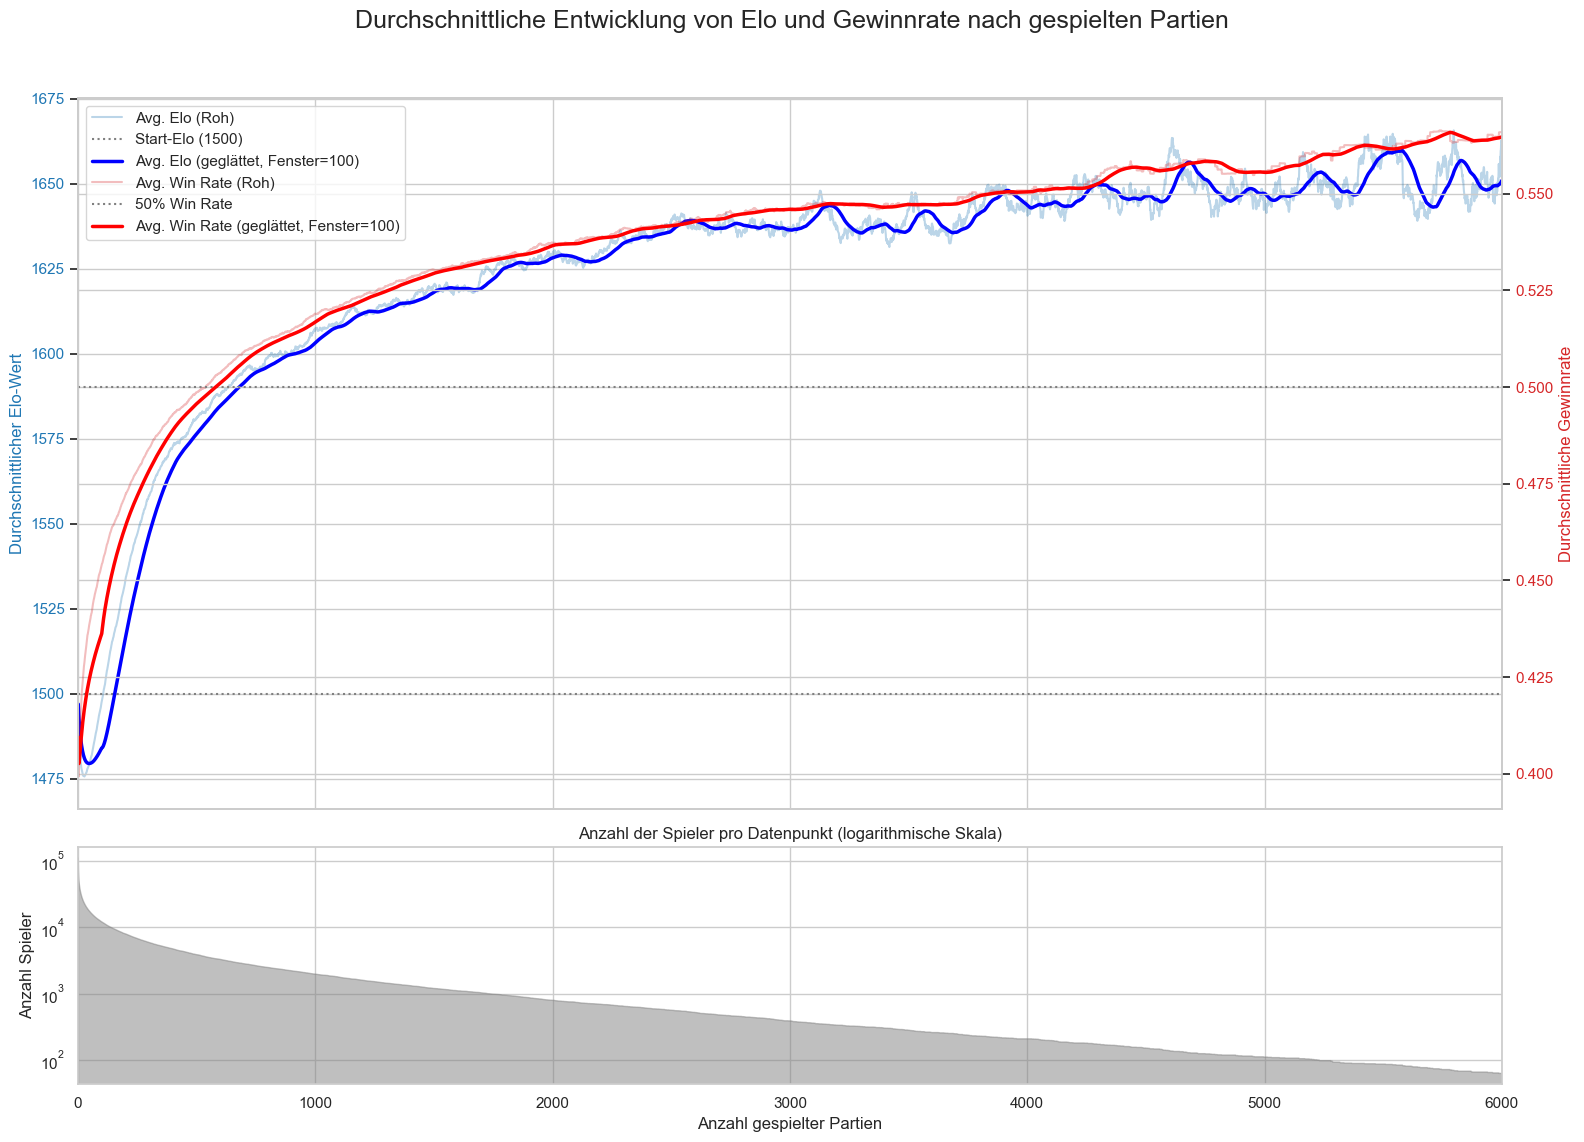

In [21]:
# Daten laden

import pandas as pd
import sqlite3

# Konfiguration
MAX_GAMES_TO_PLOT = 6000 # Begrenze die X-Achse, um den Anfang detaillierter zu sehen
DB_PATH = "../data/bsw/timeseries.sqlite"

conn = sqlite3.connect(f"file:{DB_PATH}?mode=ro", uri=True)
print("Datenbankverbindung erfolgreich hergestellt.")

query = """
    SELECT
        num_games,
        COUNT(*) AS player_count,
        AVG(win_rate) AS avg_win_rate,
        AVG(elo_value) AS avg_elo_value
    FROM timeseries
    GROUP BY num_games
    ORDER BY num_games
"""
raw_trend_df = pd.read_sql_query(query, conn)

# Beschränke die Daten auf den zu plottenden Bereich für bessere Lesbarkeit
plot_df = raw_trend_df[raw_trend_df['num_games'] <= MAX_GAMES_TO_PLOT].copy()
display(plot_df.head())

conn.close()
print("\nDatenbankverbindung geschlossen.")

# Diagramm erstellen

import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib Stil setzen
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 8) # Etwas breiter für die x-Achse

# Erstelle eine Figur mit zwei untereinander liegenden Subplots ---
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(16, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.suptitle('Durchschnittliche Entwicklung von Elo und Gewinnrate nach gespielten Partien', fontsize=18)

# Plot 1: Elo und Win Rate (obere Grafik)

# Linke Y-Achse für Elo
color1 = 'tab:blue'
ax1.set_ylabel('Durchschnittlicher Elo-Wert', color=color1, fontsize=12)
# Direkter Plot der rohen Durchschnittswerte
sns.lineplot(x='num_games', y='avg_elo_value', data=plot_df, ax=ax1, color=color1, alpha=0.3, label='Avg. Elo (Roh)')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.axhline(1500, color='gray', linestyle=':', label='Start-Elo (1500)')

# Glättung mit gleitendem Durchschnitt
# Beispiel, was rolling() macht:
#   window_size = 3, min_periods = 1
#   elo_values = [1500, 1510, 1490, 1520, 1530]
#   Position 0: Fenster ist [1500]. Durchschnitt = 1500.
#   Position 1: Fenster ist [1500, 1510]. Durchschnitt = 1505.
#   Position 2: Fenster ist [1500, 1510, 1490]. Durchschnitt = 1500.
#   Position 3: Fenster ist [1510, 1490, 1520]. Durchschnitt = 1506.67.
#   Position 4: Fenster ist [1490, 1520, 1530]. Durchschnitt = 1513.33.
window_size = 100
plot_df['elo_moving_avg'] = plot_df['avg_elo_value'].rolling(window=window_size, min_periods=1).mean()
sns.lineplot(x='num_games', y='elo_moving_avg', data=plot_df, ax=ax1, color='blue', linewidth=2.5, label=f'Avg. Elo (geglättet, Fenster={window_size})')

# Rechte Y-Achse für Win Rate
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Durchschnittliche Gewinnrate', color=color2, fontsize=12)
sns.lineplot(x='num_games', y='avg_win_rate', data=plot_df, ax=ax2, color=color2, alpha=0.3, label='Avg. Win Rate (Roh)')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.axhline(0.5, color='gray', linestyle=':', label='50% Win Rate')

# Glättung für Win Rate
plot_df['win_rate_moving_avg'] = plot_df['avg_win_rate'].rolling(window=window_size, min_periods=1).mean()
sns.lineplot(x='num_games', y='win_rate_moving_avg', data=plot_df, ax=ax2, color='red', linewidth=2.5, label=f'Avg. Win Rate (geglättet, Fenster={window_size})')

ax1.grid(True)

# KORRIGIERTE LEGENDEN-LOGIK

# Sammle Handles und Labels von beiden Achsen manuell
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Kombiniere sie und erstelle eine einzige Legende auf der ZWEITEN Achse
# ax2 ist "oben" und überschreibt nichts.
ax2.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

# Entferne die automatisch generierte Legende von der ersten Achse, falls vorhanden
if ax1.get_legend() is not None:
    ax1.get_legend().remove()

# Plot 2: Anzahl der Spieler pro Datenpunkt (untere Grafik)

ax3.set_xlabel('Anzahl gespielter Partien', fontsize=12)
ax3.set_ylabel('Anzahl Spieler', fontsize=12)
ax3.fill_between(plot_df['num_games'], plot_df['player_count'], color='gray', alpha=0.5)
ax3.set_yscale('log')
ax3.set_title('Anzahl der Spieler pro Datenpunkt (logarithmische Skala)', fontsize=12)
ax3.grid(True)

# Setze das X-Achsen-Limit NACHDEM alle Daten geplottet wurden
ax1.set_xlim(0, MAX_GAMES_TO_PLOT)

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Passe das Layout an
plt.show()

## 5.6 Spieler-Selektion

**Fragestellung:** Wo ziehen wir die Grenze für "gute Spieler"?

**Entscheidung**

TODO
Basierend auf diesem Diagramm können wir einen fundierten Schwellenwert festlegen. Z.B. "Wir nehmen alle Spieler mit elo_final >= 1700", was vielleicht die Top 20% der Spielerbasis darstellt.

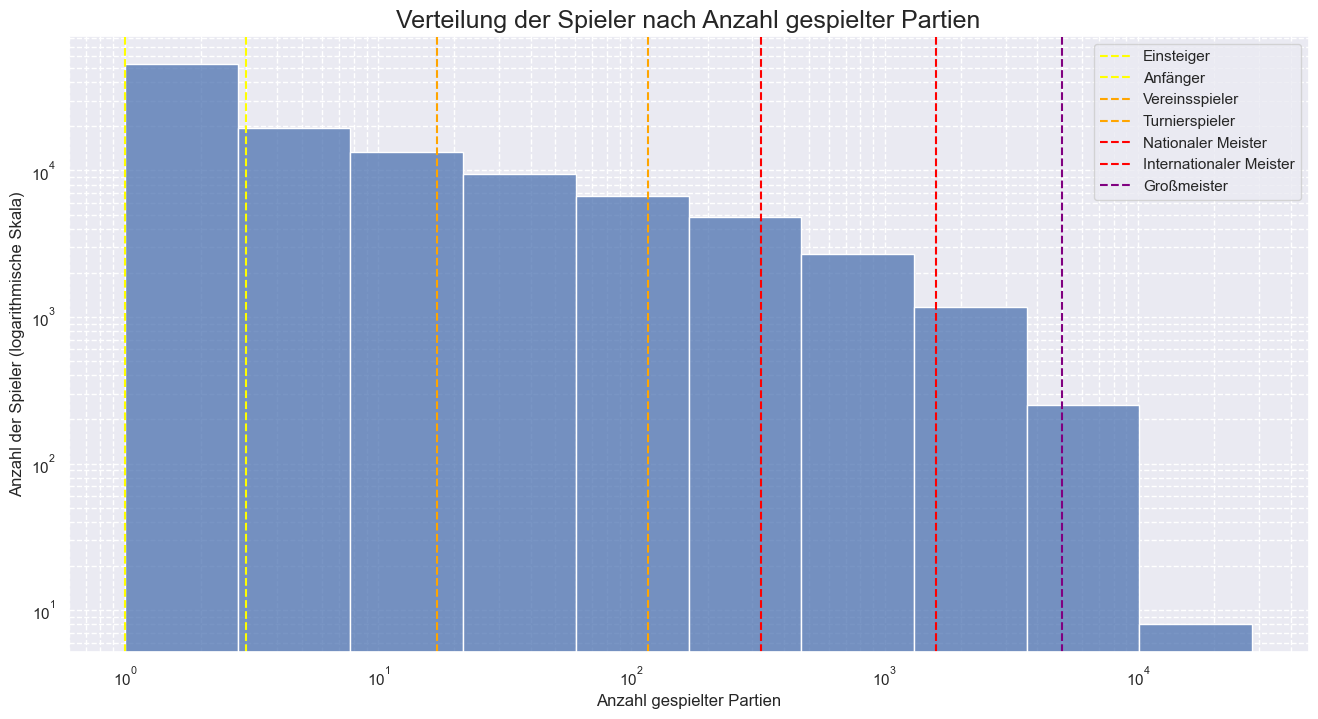


Die unteren 5% der Spieler haben <= 1 Partien gespielt.
Die oberen 5% der Spieler haben >= 324 Partien gespielt.


In [81]:
# Visualisierung als Histogramm (Balkendiagramm)
plt.figure(figsize=(16, 8))

# Wir verwenden ein Histogramm, um die Spieler in Erfahrungs-Bins zu gruppieren.
# Die logarithmische Skala auf beiden Achsen hilft, die extreme Verteilung darzustellen.
ax = sns.histplot(data=player_exp_df, x='num_games', log_scale=True,  bins=10) # x-Achse logarithmisch
ax.set_yscale('log')  # y-Achse logarithmisch

plt.title(f'Verteilung der Spieler nach Anzahl gespielter Partien', fontsize=18)
plt.xlabel('Anzahl gespielter Partien', fontsize=12)
plt.ylabel('Anzahl der Spieler (logarithmische Skala)', fontsize=12)
plt.grid(True, which="both", ls="--")

# Füge vertikale Linien für die Schach-Elo-Kategorien hinzu (angenommene Spieleanzahl)
# Diese Schwellen sind Hypothesen!
plt.axvline(1, color='yellow', linestyle='--', label='Einsteiger')
plt.axvline(3, color='yellow', linestyle='--', label='Anfänger')
plt.axvline(17, color='orange', linestyle='--', label='Vereinsspieler')
plt.axvline(116, color='orange', linestyle='--', label='Turnierspieler')
plt.axvline(324, color='red', linestyle='--', label='Nationaler Meister')
plt.axvline(1595, color='red', linestyle='--', label='Internationaler Meister')
plt.axvline(4992, color='purple', linestyle='--', label='Großmeister')
plt.legend()

plt.show()

# Wir können nun unsere Ziel-Elos an die Perzentile der Spielerfahrung koppeln
p5_games = player_exp_df['num_games'].quantile(0.05)
p95_games = player_exp_df['num_games'].quantile(0.95)
print(f"\nDie unteren 5% der Spieler haben <= {p5_games:.0f} Partien gespielt.")
print(f"Die oberen 5% der Spieler haben >= {p95_games:.0f} Partien gespielt.")

**Interpretation**

Dies zeigt uns die Verteilung der Spielstärke im Datensatz. Wir sehen, wo die Mehrheit der Spieler liegt und wie viele "Experten" (z.B. Elo > 2000) es gibt.